In [9]:
import math
import numpy as np
import os
import pprint

from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS
from evo.tools import file_interface
from evo.core import sync
from evo.core.sync import TrajectoryPair

from os import path
from tools.tum_plots import *

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

%load_ext autoreload
%autoreload 2

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Read dataset configuration
data_set = "kiss-v3"

data_root = path.join("tum_format", data_set)

gps_pose_name = "ekf_gt_gps.tum"
ekf_pose_name = "ekf_pose_with_covariance.tum"
kiss_pose_name = "odometry.tum"

gps_file = path.join(data_root, gps_pose_name)
ekf_file = path.join(data_root, ekf_pose_name)
kiss_file = path.join(data_root, kiss_pose_name)

In [23]:
traj_ref = file_interface.read_tum_trajectory_file(gps_file)
traj_ekf = file_interface.read_tum_trajectory_file(ekf_file)
traj_kiss = file_interface.read_tum_trajectory_file(kiss_file)

kiss_compare_traj = sync.associate_trajectories(traj_ref, traj_kiss)
ekf_compare_traj = sync.associate_trajectories(traj_ref, traj_ekf)

In [ ]:
def plot_compare(traj: TrajectoryPair, align_origin=False, print_stats=False, plot_error='ape'):
    
    if align_origin:
        traj = align_origin(traj)
    traj_ref, traj_est = traj
    
    ape_metric = metrics.APE()
    ape_metric.process_data((traj_ref, traj_est))
    
    if print_stats:
        ape_stats = ape_metric.get_all_statistics()
        pprint.pprint(ape_stats)
    
    if plot_error == 'ape':
        plot_ape_errors(traj_ref, traj_est, ape_metric, ape_stats)
    elif plot_error == 'rpy':        
        plot_rpy_errors(traj_ref, traj_est)
    elif plot_error == 'xyz':
        plot_xyz_errors(traj_ref, traj_est)
    else:
        raise RuntimeError(f"Unsupported plot type: plot_error={plot_error}. Must be one of ['ape', 'rpy', 'xyz']!")

## Interactive

In [2]:
# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

In [ ]:
ape_metric = metrics.APE()
ape_metric.process_data((traj_ref, traj_est))
ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)
plot_ape_errors(traj_ref, traj_est, ape_metric, ape_stats)

In [5]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})


interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

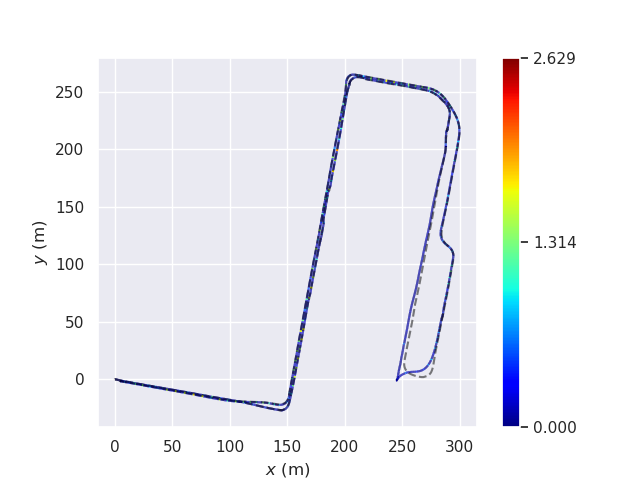

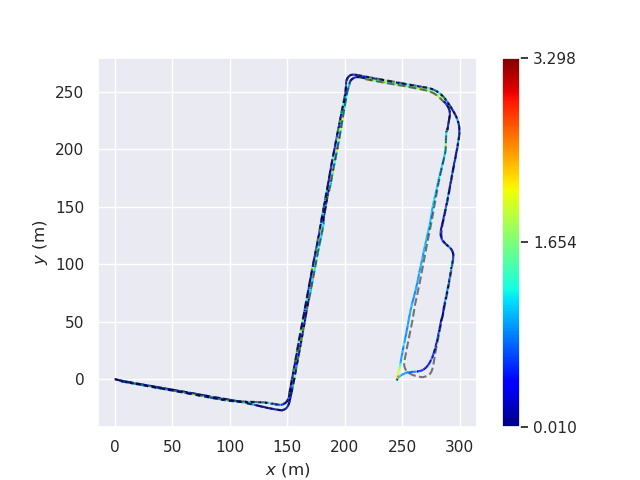

In [7]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})